# U-Net 
Mejoras: ReflectionPad3d (en vez de zero padding), posibilidad de agregar dropout, posibilidad de optar por upsamplig o convtranspose


In [1]:
import os 
import time
import math
import torch
import random
import numpy as np
import pandas as pd
from tqdm import tqdm
import torch.nn as nn
from glob import glob
from pathlib import Path
import matplotlib.pyplot as plt
from torchsummary import summary
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.metrics import f1_score, jaccard_score

In [2]:
"""
______________________________________encoding block_______________________________
"""
class encoding_block(nn.Module):
    def __init__(self, in_size, out_size, kernel_size=3, padding=0, stride=1, dilation=1, dropout=True):
        super().__init__()
            
        layers = [nn.ReflectionPad3d(padding=(kernel_size -1)//2),
                  nn.Conv3d(in_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation),
                  nn.BatchNorm3d(out_size),
                  nn.PReLU(),
                  nn.ReflectionPad3d(padding=(kernel_size - 1)//2),
                  nn.Conv3d(out_size, out_size, kernel_size=kernel_size, padding=padding, stride=stride, dilation=dilation),
                  nn.PReLU(),
                  nn.BatchNorm3d(out_size),
                  nn.PReLU(),
                  ]

        if dropout:
            layers.append(nn.Dropout())

        self.encoding_block = nn.Sequential(*layers)

    def forward(self, input):

        output = self.encoding_block(input)

        return output
"""
______________________________________decoding block_______________________________
"""
class decoding_block(nn.Module):
    def __init__(self, in_size, out_size, upsampling=True):
        super().__init__()

        if upsampling:
            self.up = nn.Sequential(nn.Upsample(mode='nearest', scale_factor=2),
                                    nn.Conv3d(in_size, out_size, kernel_size=1))

        else:
            self.up = nn.ConvTranspose3d(in_size, out_size, kernel_size=2, stride=2)

        self.conv = encoding_block(in_size, out_size)

    def forward(self, input):

        output = self.up(input)

        return output

"""
______________________________________Main UNet architecture_______________________________
"""
class UNet(nn.Module):
    def __init__(self, in_channels=4, out_channels=1, features=[64, 128, 256, 512, 1024], dropout=False,  upsampling=True):
        super().__init__()
        
        self.ups = nn.ModuleList() #no se puede usar una lista tipo [] porque se nececita almacenar capas convolucionales
        self.downs = nn.ModuleList() 
        
        self.pool = nn.MaxPool3d(kernel_size=2, stride=2)
        
#Encoder
        for feature in features:
            self.downs.append(encoding_block(in_channels, feature, dropout = dropout))
            in_channels = feature
#Base        
        self.bottleneck = encoding_block(features[-1], features[-1]*2) #512 a 1024
            
#Decoder
        for feature in reversed(features):#los tamaños ahora van del ultimo al primero
            self.ups.append(decoding_block(feature*2, feature))
            self.ups.append(encoding_block(feature*2, feature))
            
#Final
        self.final_conv = nn.Conv3d(features[0], out_channels, kernel_size=1)
                   

    def forward(self, x):
        skip_connections = []
        
        for down in self.downs:
            x = down(x)
            skip_connections.append(x)
            x = self.pool(x)

        
        x = self.bottleneck(x)
        
        skip_connections = skip_connections[::-1]# da vuelta la lista para usarla en la subida
        
        for idx in range(0, len(self.ups), 2):#se hace un paso de 2 porque un solo paso va a equivaler al up and doubleconv
            x = self.ups[idx](x)
            skip_connection = skip_connections[idx//2]
            concat_skip = torch.cat((skip_connection, x), dim=1)
            x = self.ups[idx+1](concat_skip)

            
        return self.final_conv(x)

## * Comprobar funcionamiento 
Se le ingresa a la arquitectura un tensor random con las dimensiones de los volúmenes de entrada y se verifica que la salida sea con las dimensiones de las dosis

In [3]:
model = UNet()
x = torch.randn((1, 4, 64, 64, 64))
output = model(x)
output.shape

torch.Size([1, 1, 64, 64, 64])

# Métricas

## IoU

In [4]:
def dice(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)
    return   torch.mean((2 * intersect) /(union+smooth))

## Dice

In [5]:
def iou(true, pred, smooth=0.0000001):
    true=torch.round(true, decimals=1)
    pred=torch.round(pred, decimals=1)
    intersect = torch.sum((true == pred).int())
    union = math.prod(true.shape) + math.prod(pred.shape)-intersect
    return   torch.mean(intersect /(union+smooth))

# BCEDiceLoss

In [6]:
class BCEDiceLoss(nn.Module):
    def __init__(self, weight=None, size_average=True):
        super().__init__()

    def forward(self, true, pred):
        true = true.view(-1)
        pred = pred.view(-1)
        # BCE loss
        bce_loss = nn.BCEWithLogitsLoss()(true, pred).double()
        # Dice Loss
        dice_coef = ((-(true-pred)**2+1).double().sum()) / (math.prod(true.shape))
        return bce_loss + (1 - dice_coef)

# Utils

## Seed

In [7]:
def seeding(seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    

## Calculo del tiempo

In [8]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time/60)
    elapsed_secs = int(elapsed_time - (elapsed_mins*60))
    
    return elapsed_mins, elapsed_secs

## Data loader

In [9]:
def create_dir(path):
    if not os.path.exists(path):
        os.makedirs(path)

In [10]:
class Dataset (torch.utils.data.Dataset):
    def __init__(self, x, y):
        self.x = x
        self.y = y
       
    def __len__(self):
        assert len(self.x) == len(self.y), "La cantidad de volumenes no es equivalente a la cantidad de mascaras"
        return len(self.x)
    
    
    def __getitem__(self,ix):
        img = np.load(self.x[ix])
        mask = np.load(self.y[ix])
        img_oh = (np.arange(4) == img[...,None]).astype(np.float64)
        img_tensor= torch.tensor(img_oh).permute(3, 0, 1, 2)
        mask_e = mask/36.25
        mask_tensor = torch.tensor(mask_e).unsqueeze(0)
        
        return img_tensor, mask_tensor

In [11]:
def cargar_carpetas(carpeta, carpeta_estruc, carpeta_dosis ):
    direc = Path(carpeta +"/")
    estruc = [direc/carpeta_estruc/i for i in os.listdir(direc/carpeta_estruc)]
    dosis = [direc/carpeta_dosis/i for i in os.listdir(direc/carpeta_dosis)]
    estruc = sorted(estruc)
    dosis = sorted(dosis)
    print("Carpetas cargadas")
    if len(estruc) != len(dosis):
        print("La cantidad de volumenes no es equivalente a la cantidad de mascaras")
    print('La carpeta {} tiene {} volumenes y la carpeta {} tiene {} mascaras'.format(carpeta_estruc, len(estruc),carpeta_dosis, len(dosis)))
    
    return estruc, dosis

# * Entrenamiento de un solo volumen

In [12]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')
dataset = Dataset(estruc[63:64], dosis[63:64])
dataloader = torch.utils.data.DataLoader(dataset, batch_size=1, shuffle=True)
x, y = next(iter(dataloader))

Carpetas cargadas
La carpeta Estructuras tiene 240 volumenes y la carpeta Dosis tiene 240 mascaras


In [13]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [14]:
def fit(model, X, y, epochs=1, lr=1e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.MSELoss()
    model.to(device)
    X = X.to(device=device, dtype=torch.float)
    y = y.to(device=device, dtype=torch.float)
    model.train()
    for epoch in range(1, epochs+1):
        optimizer.zero_grad()
        y_hat = model(X)
        loss = criterion(y_hat, y)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, y)
        dices = dice(y_hat, y)
        print(f"Epoch {epoch}/{epochs} loss {loss.item():.5f} iou {ious:.3f} dice {dices:.3f}")

In [12]:
fit(model, x, y, epochs=5000)

In [17]:
model.eval()
with torch.no_grad():
    output = model(x.to(device=device, dtype=torch.float))[0]

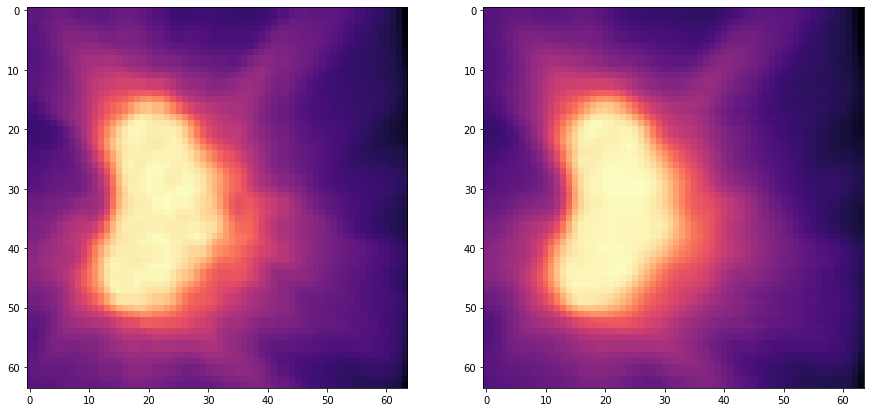

In [18]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,10))
ax1.imshow(y[0,0,:,:,24],cmap="magma")
ax2.imshow(output[0,:,:,24].squeeze().cpu().numpy(),cmap="magma")
plt.show()

# * Resumen de arquitectura

In [19]:
summary(model, (4, 64, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
   ReflectionPad3d-1        [-1, 4, 66, 66, 66]               0
            Conv3d-2       [-1, 64, 64, 64, 64]           6,976
       BatchNorm3d-3       [-1, 64, 64, 64, 64]             128
             PReLU-4       [-1, 64, 64, 64, 64]               1
   ReflectionPad3d-5       [-1, 64, 66, 66, 66]               0
            Conv3d-6       [-1, 64, 64, 64, 64]         110,656
             PReLU-7       [-1, 64, 64, 64, 64]               1
       BatchNorm3d-8       [-1, 64, 64, 64, 64]             128
             PReLU-9       [-1, 64, 64, 64, 64]               1
   encoding_block-10       [-1, 64, 64, 64, 64]               0
        MaxPool3d-11       [-1, 64, 32, 32, 32]               0
  ReflectionPad3d-12       [-1, 64, 34, 34, 34]               0
           Conv3d-13      [-1, 128, 32, 32, 32]         221,312
      BatchNorm3d-14      [-1, 128, 32,

# Entrenamiento

In [13]:
estruc, dosis = cargar_carpetas('DatasetPI/EntrenamientoPI', 'Estructuras', 'Dosis')

Carpetas cargadas
La carpeta Estructuras tiene 240 volumenes y la carpeta Dosis tiene 240 mascaras


In [14]:
dataset = {
    "train" : Dataset(estruc[:180], dosis[:180]),
    "test" : Dataset(estruc[180:], dosis[180:])}

print(f'La cantidad de imágenes de entrenamiento son {len(dataset["train"])} y la cantidad de validación son {len(dataset["test"])}.')

La cantidad de imágenes de entrenamiento son 180 y la cantidad de validación son 60.


In [15]:
dataloader = {
    "train" : torch.utils.data.DataLoader(dataset["train"], batch_size=2, shuffle=True, pin_memory=True),
    "test" : torch.utils.data.DataLoader(dataset["test"], batch_size=2, pin_memory=True) }

imges, maskes = next(iter(dataloader["train"]))
imges.shape, maskes.shape

(torch.Size([2, 4, 64, 64, 64]), torch.Size([2, 1, 64, 64, 64]))

In [16]:
def train(model, dataloader, hist, met, optimizer, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['train'])
    train_loss= []
    model.train()
    for imges, maskes in bar:
        imges, maskes = imges.to(device, dtype=torch.float), maskes.to(device, dtype=torch.float)
        optimizer.zero_grad()
        y_pred = model(imges)
        loss = loss_fn(y_pred, maskes)
        loss.backward() 
        optimizer.step() 
        ious = iou(y_pred, maskes)
        dices = dice(y_pred, maskes)
        train_loss.append(loss.item())
        epoch_loss += loss.item()
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
    hist['loss'].append(np.mean(train_loss))
    met["IoU"].append(np.mean(ious.cpu().numpy()*1))
    met["Dice"].append(np.mean(dices.cpu().numpy()*1))
    epoch_loss = epoch_loss/len(bar)
    
    return epoch_loss, hist, met

In [17]:
def evaluate(model, dataloader, hist, met, loss_fn, device):
    epoch_loss = 0.0
    bar = tqdm(dataloader['test'])
    test_loss = []
    model.eval()
    with torch.no_grad():
        for imges, maskes in bar:
            imges, maskes = imges.to(device,dtype=torch.float), maskes.to(device, dtype=torch.float)
            y_pred = model(imges)
            loss = loss_fn(y_pred, maskes)
            epoch_loss += loss.item()
            test_loss.append(loss.item())
            ious = iou(y_pred, maskes)
            dices = dice(y_pred, maskes)
            bar.set_description(f"test_loss {np.mean(test_loss):.5f} iou {ious:.3f} dice {dices:.3f}")
        hist['test_loss'].append(np.mean(test_loss))
        met["IoU_test"].append(np.mean(ious.cpu().numpy()*1))
        met["Dice_test"].append(np.mean(dices.cpu().numpy()*1))
        epoch_loss = epoch_loss/len(bar)
    
    return epoch_loss, hist, met

In [19]:
device = torch.device('cuda')
model = UNet()
model = model.to(device)

In [20]:
def fit(epochs=10, loss_fn = torch.nn.MSELoss(), model=model, device=device):
    if __name__ == "__main__":

        seeding(42)
        create_dir("file")

        epochs = epochs
        lr = 1e-4
        checkpoint_path = "file/checkpoint.pth" # Para guardar el modelo 

        dataloaders = dataloader

        optimizer = torch.optim.Adam(model.parameters(), lr = lr)
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=5, min_lr= 1e-8)
        loss_fn = loss_fn
        
        # Entrenamiento
        hist = {'loss': [], 'test_loss': []}
        met = {"IoU": [], "Dice": [], "IoU_test": [], "Dice_test": []}
        best_valid_loss = float("inf")
        start_time = time.time()

        for epoch in range(1, epochs+1):
            print(f"\nEpoch {epoch}/{epochs}")

            train_loss, hist, met = train(model, dataloaders, hist, met, optimizer, loss_fn, device)
            valid_loss, hist, met = evaluate(model, dataloaders, hist, met, loss_fn, device)
        # Guardar el modelo entrenado 
            if valid_loss < best_valid_loss:
                data_str = f"Valid loss improved from {best_valid_loss:.4f} to {valid_loss:.4f}. Saving checkpoint: {checkpoint_path}"
                print(data_str)

                best_valid_loss = valid_loss
                torch.save(model.state_dict(), checkpoint_path)
        # Mostrar avance del entrenamiento    
        end_time = time.time()
        epoch_mins, epoch_secs = epoch_time(start_time, end_time)
        data_str = f' Entrenamiento de {epochs} epocas finalizado en {epoch_mins}m {epoch_secs}s\n'
        print()
        print(data_str)
        
        return hist, met

## * Entrenamiento de 10 épocas con torch.nn.MSELoss


In [19]:
hist, met = fit(epochs=10, loss_fn = torch.nn.MSELoss())


Epoch 1/10


test_loss 0.01814 iou 0.303 dice 0.465: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]


Valid loss improved from inf to 0.0181. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.01801 iou 0.220 dice 0.361: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.91it/s]


Valid loss improved from 0.0181 to 0.0180. Saving checkpoint: file/checkpoint.pth

Epoch 3/10


test_loss 0.00865 iou 0.369 dice 0.539: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.22it/s]


Valid loss improved from 0.0180 to 0.0086. Saving checkpoint: file/checkpoint.pth

Epoch 4/10


test_loss 0.12345 iou 0.197 dice 0.328: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.89it/s]



Epoch 5/10


test_loss 0.00750 iou 0.346 dice 0.515: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]


Valid loss improved from 0.0086 to 0.0075. Saving checkpoint: file/checkpoint.pth

Epoch 6/10


test_loss 0.00600 iou 0.366 dice 0.536: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.82it/s]


Valid loss improved from 0.0075 to 0.0060. Saving checkpoint: file/checkpoint.pth

Epoch 7/10


test_loss 0.01634 iou 0.295 dice 0.455: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.77it/s]



Epoch 8/10


test_loss 0.00634 iou 0.325 dice 0.490: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.70it/s]



Epoch 9/10


test_loss 0.01525 iou 0.220 dice 0.360: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.71it/s]



Epoch 10/10


test_loss 0.00454 iou 0.448 dice 0.619: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.68it/s]


Valid loss improved from 0.0060 to 0.0045. Saving checkpoint: file/checkpoint.pth

 Entrenamiento de 10 epocas finalizado en 5m 30s



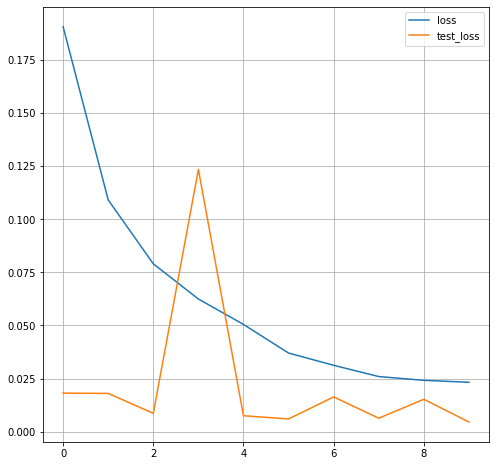

In [20]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

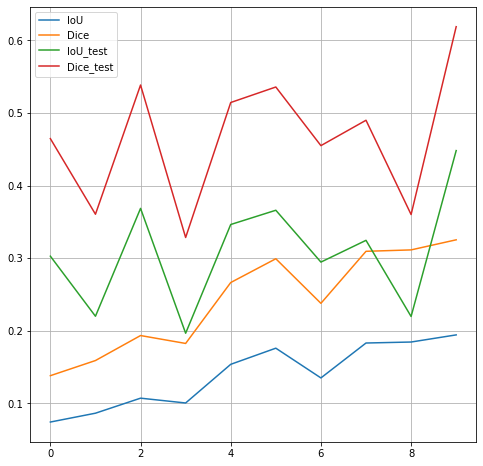

In [21]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

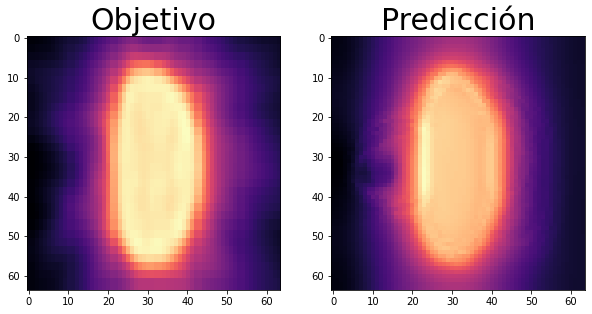

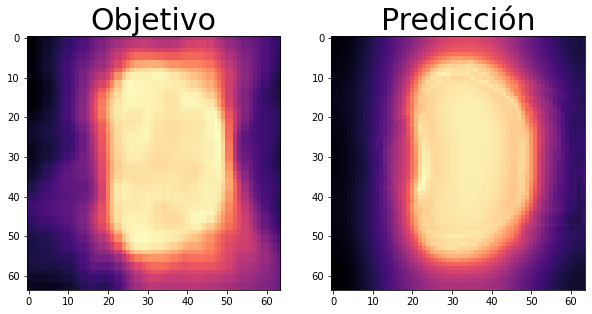

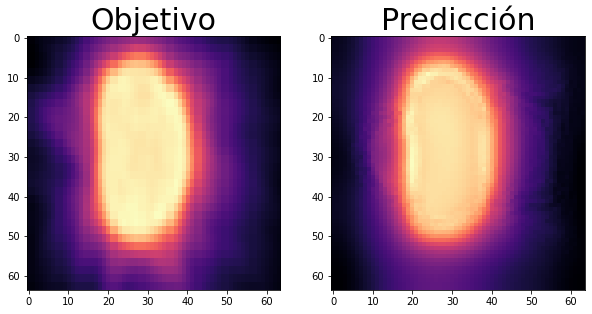

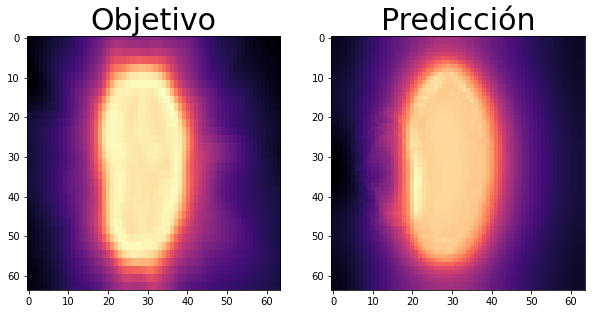

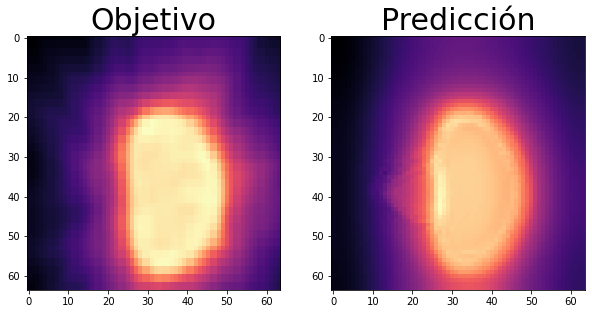

In [22]:
#10 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 100 épocas con torch.nn.MSELoss


In [23]:
hist, met = fit(epochs=100, loss_fn = torch.nn.MSELoss())


Epoch 1/100


test_loss 0.00939 iou 0.355 dice 0.525: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.90it/s]


Valid loss improved from inf to 0.0094. Saving checkpoint: file/checkpoint.pth

Epoch 2/100


test_loss 0.00434 iou 0.481 dice 0.649: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.84it/s]


Valid loss improved from 0.0094 to 0.0043. Saving checkpoint: file/checkpoint.pth

Epoch 3/100


test_loss 0.00433 iou 0.445 dice 0.616: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.90it/s]


Valid loss improved from 0.0043 to 0.0043. Saving checkpoint: file/checkpoint.pth

Epoch 4/100


test_loss 0.00440 iou 0.437 dice 0.608: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.77it/s]



Epoch 5/100


test_loss 0.00342 iou 0.508 dice 0.674: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.90it/s]


Valid loss improved from 0.0043 to 0.0034. Saving checkpoint: file/checkpoint.pth

Epoch 6/100


test_loss 0.00361 iou 0.486 dice 0.654: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.67it/s]



Epoch 7/100


test_loss 0.00488 iou 0.399 dice 0.570: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.79it/s]



Epoch 8/100


test_loss 0.00309 iou 0.511 dice 0.676: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.84it/s]


Valid loss improved from 0.0034 to 0.0031. Saving checkpoint: file/checkpoint.pth

Epoch 9/100


test_loss 0.00256 iou 0.542 dice 0.703: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.84it/s]


Valid loss improved from 0.0031 to 0.0026. Saving checkpoint: file/checkpoint.pth

Epoch 10/100


test_loss 0.00242 iou 0.538 dice 0.699: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.73it/s]


Valid loss improved from 0.0026 to 0.0024. Saving checkpoint: file/checkpoint.pth

Epoch 11/100


test_loss 0.00258 iou 0.479 dice 0.647: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.69it/s]



Epoch 12/100


test_loss 0.00240 iou 0.543 dice 0.704: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.49it/s]


Valid loss improved from 0.0024 to 0.0024. Saving checkpoint: file/checkpoint.pth

Epoch 13/100


test_loss 0.00272 iou 0.509 dice 0.675: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.41it/s]



Epoch 14/100


test_loss 0.00227 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.43it/s]


Valid loss improved from 0.0024 to 0.0023. Saving checkpoint: file/checkpoint.pth

Epoch 15/100


test_loss 0.00222 iou 0.527 dice 0.690: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.49it/s]


Valid loss improved from 0.0023 to 0.0022. Saving checkpoint: file/checkpoint.pth

Epoch 16/100


test_loss 0.00184 iou 0.569 dice 0.726: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.35it/s]


Valid loss improved from 0.0022 to 0.0018. Saving checkpoint: file/checkpoint.pth

Epoch 17/100


test_loss 0.00289 iou 0.520 dice 0.684: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.92it/s]



Epoch 18/100


test_loss 0.00258 iou 0.528 dice 0.691: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.30it/s]



Epoch 19/100


test_loss 0.00945 iou 0.290 dice 0.450: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.37it/s]



Epoch 20/100


test_loss 0.01207 iou 0.291 dice 0.451: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.36it/s]



Epoch 21/100


test_loss 0.00740 iou 0.433 dice 0.605: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.31it/s]



Epoch 22/100


test_loss 0.00443 iou 0.442 dice 0.613: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.60it/s]



Epoch 23/100


test_loss 0.00243 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]



Epoch 24/100


test_loss 0.00217 iou 0.487 dice 0.655: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.48it/s]



Epoch 25/100


test_loss 0.00199 iou 0.575 dice 0.730: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.16it/s]



Epoch 26/100


test_loss 0.00252 iou 0.527 dice 0.690: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.58it/s]



Epoch 27/100


test_loss 0.00200 iou 0.492 dice 0.659: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]



Epoch 28/100


test_loss 0.00277 iou 0.506 dice 0.672: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.36it/s]



Epoch 29/100


test_loss 0.00163 iou 0.588 dice 0.740: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.41it/s]


Valid loss improved from 0.0018 to 0.0016. Saving checkpoint: file/checkpoint.pth

Epoch 30/100


test_loss 0.00183 iou 0.568 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.41it/s]



Epoch 31/100


test_loss 0.00177 iou 0.558 dice 0.716: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.38it/s]



Epoch 32/100


test_loss 0.00237 iou 0.520 dice 0.684: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.40it/s]



Epoch 33/100


test_loss 0.00171 iou 0.581 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]



Epoch 34/100


test_loss 0.00231 iou 0.557 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.27it/s]



Epoch 35/100


test_loss 0.00149 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.51it/s]


Valid loss improved from 0.0016 to 0.0015. Saving checkpoint: file/checkpoint.pth

Epoch 36/100


test_loss 0.00160 iou 0.578 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 37/100


test_loss 0.00165 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.10it/s]



Epoch 38/100


test_loss 0.00155 iou 0.569 dice 0.725: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.33it/s]



Epoch 39/100


test_loss 0.00142 iou 0.578 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]


Valid loss improved from 0.0015 to 0.0014. Saving checkpoint: file/checkpoint.pth

Epoch 40/100


test_loss 0.00178 iou 0.563 dice 0.721: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 41/100


test_loss 0.00172 iou 0.560 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.50it/s]



Epoch 42/100


test_loss 0.00189 iou 0.555 dice 0.713: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]



Epoch 43/100


test_loss 0.00164 iou 0.581 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.47it/s]



Epoch 44/100


test_loss 0.00184 iou 0.573 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.23it/s]



Epoch 45/100


test_loss 0.00153 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.36it/s]



Epoch 46/100


test_loss 0.00159 iou 0.578 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.51it/s]



Epoch 47/100


test_loss 0.00149 iou 0.600 dice 0.750: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.23it/s]



Epoch 48/100


test_loss 0.00167 iou 0.583 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]



Epoch 49/100


test_loss 0.00159 iou 0.553 dice 0.712: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.02it/s]



Epoch 50/100


test_loss 0.00154 iou 0.543 dice 0.704: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 51/100


test_loss 0.00150 iou 0.568 dice 0.725: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]



Epoch 52/100


test_loss 0.00190 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]



Epoch 53/100


test_loss 0.00198 iou 0.551 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 54/100


test_loss 0.00174 iou 0.548 dice 0.708: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.02it/s]



Epoch 55/100


test_loss 0.00165 iou 0.568 dice 0.725: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 56/100


test_loss 0.00149 iou 0.560 dice 0.718: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.02it/s]



Epoch 57/100


test_loss 0.00137 iou 0.581 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.02it/s]


Valid loss improved from 0.0014 to 0.0014. Saving checkpoint: file/checkpoint.pth

Epoch 58/100


test_loss 0.00137 iou 0.576 dice 0.731: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]


Valid loss improved from 0.0014 to 0.0014. Saving checkpoint: file/checkpoint.pth

Epoch 59/100


test_loss 0.00142 iou 0.574 dice 0.729: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]



Epoch 60/100


test_loss 0.00160 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]



Epoch 61/100


test_loss 0.00166 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]



Epoch 62/100


test_loss 0.00148 iou 0.557 dice 0.716: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]



Epoch 63/100


test_loss 0.00145 iou 0.547 dice 0.707: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 64/100


test_loss 0.00196 iou 0.499 dice 0.666: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]



Epoch 65/100


test_loss 0.00153 iou 0.569 dice 0.726: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]



Epoch 66/100


test_loss 0.00133 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]


Valid loss improved from 0.0014 to 0.0013. Saving checkpoint: file/checkpoint.pth

Epoch 67/100


test_loss 0.00171 iou 0.551 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 68/100


test_loss 0.00166 iou 0.558 dice 0.716: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.85it/s]



Epoch 69/100


test_loss 0.00133 iou 0.585 dice 0.738: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]



Epoch 70/100


test_loss 0.00124 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]


Valid loss improved from 0.0013 to 0.0012. Saving checkpoint: file/checkpoint.pth

Epoch 71/100


test_loss 0.00176 iou 0.572 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]



Epoch 72/100


test_loss 0.00147 iou 0.572 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]



Epoch 73/100


test_loss 0.00127 iou 0.591 dice 0.743: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]



Epoch 74/100


test_loss 0.00128 iou 0.599 dice 0.749: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.08it/s]



Epoch 75/100


test_loss 0.00151 iou 0.574 dice 0.729: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]



Epoch 76/100


test_loss 0.00137 iou 0.585 dice 0.738: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]



Epoch 77/100


test_loss 0.00144 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 78/100


test_loss 0.00141 iou 0.589 dice 0.742: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.02it/s]



Epoch 79/100


test_loss 0.00143 iou 0.582 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 80/100


test_loss 0.00138 iou 0.540 dice 0.701: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.07it/s]



Epoch 81/100


test_loss 0.00134 iou 0.589 dice 0.742: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 82/100


test_loss 0.00150 iou 0.587 dice 0.740: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 83/100


test_loss 0.00155 iou 0.568 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 84/100


test_loss 0.00122 iou 0.589 dice 0.741: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]


Valid loss improved from 0.0012 to 0.0012. Saving checkpoint: file/checkpoint.pth

Epoch 85/100


test_loss 0.00137 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]



Epoch 86/100


test_loss 0.00132 iou 0.570 dice 0.726: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]



Epoch 87/100


test_loss 0.00497 iou 0.350 dice 0.519: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]



Epoch 88/100


test_loss 0.00251 iou 0.506 dice 0.672: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.99it/s]



Epoch 89/100


test_loss 0.00204 iou 0.499 dice 0.666: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.07it/s]



Epoch 90/100


test_loss 0.00138 iou 0.587 dice 0.740: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]



Epoch 91/100


test_loss 0.00142 iou 0.564 dice 0.722: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]



Epoch 92/100


test_loss 0.00131 iou 0.571 dice 0.727: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.06it/s]



Epoch 93/100


test_loss 0.00128 iou 0.597 dice 0.748: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]



Epoch 94/100


test_loss 0.00130 iou 0.613 dice 0.760: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.84it/s]



Epoch 95/100


test_loss 0.00128 iou 0.614 dice 0.761: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 96/100


test_loss 0.00159 iou 0.572 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.04it/s]



Epoch 97/100


test_loss 0.00120 iou 0.620 dice 0.766: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]


Valid loss improved from 0.0012 to 0.0012. Saving checkpoint: file/checkpoint.pth

Epoch 98/100


test_loss 0.00132 iou 0.595 dice 0.746: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]



Epoch 99/100


test_loss 0.00143 iou 0.585 dice 0.738: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]



Epoch 100/100


test_loss 0.00125 iou 0.598 dice 0.748: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.91it/s]


 Entrenamiento de 100 epocas finalizado en 95m 37s



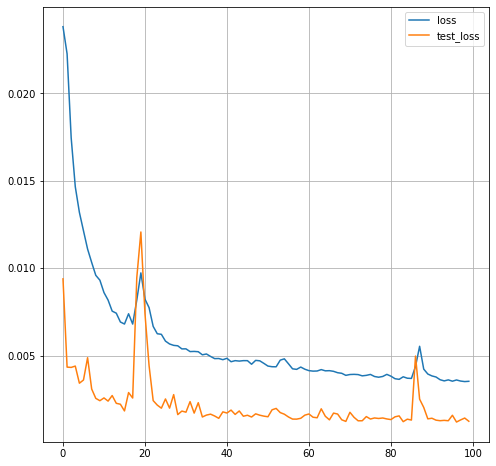

In [24]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

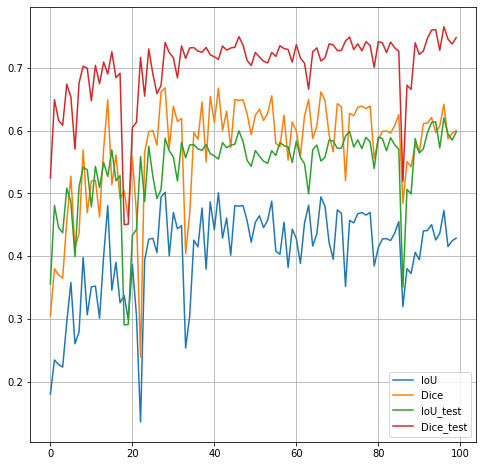

In [26]:
#100 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

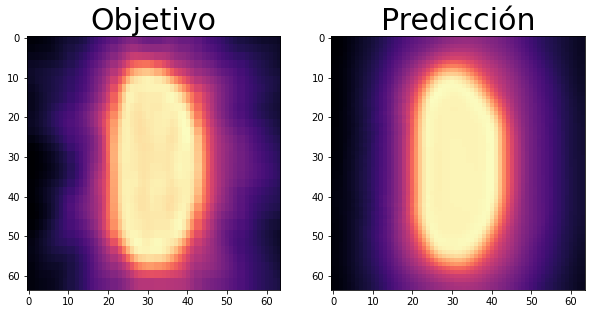

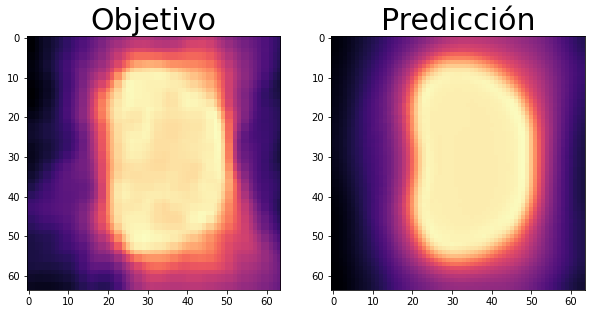

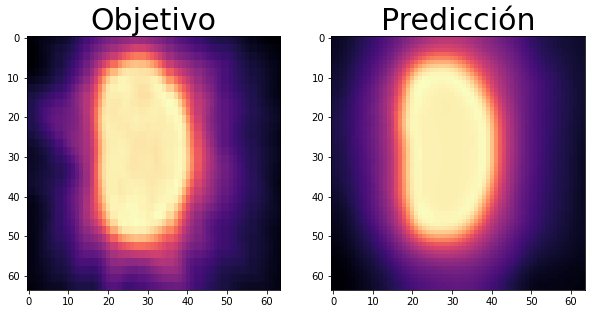

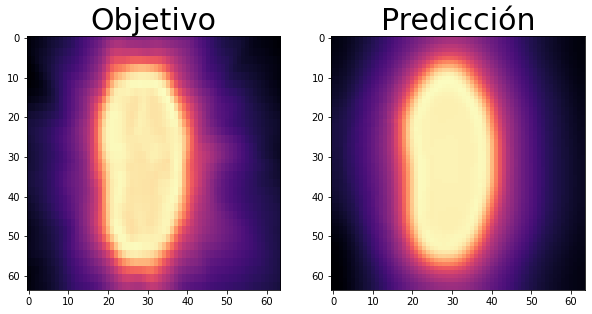

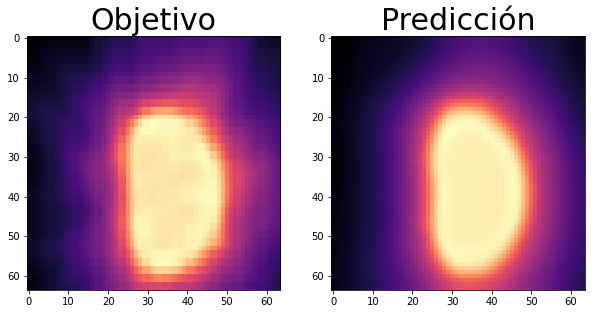

In [27]:
#100 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 10 épocas con torch.nn.L1Loss


In [25]:
hist, met = fit(epochs=10, loss_fn = torch.nn.L1Loss())


Epoch 1/10


test_loss 0.02858 iou 0.574 dice 0.730: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.60it/s]


Valid loss improved from inf to 0.0286. Saving checkpoint: file/checkpoint.pth

Epoch 2/10


test_loss 0.02449 iou 0.611 dice 0.758: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.58it/s]


Valid loss improved from 0.0286 to 0.0245. Saving checkpoint: file/checkpoint.pth

Epoch 3/10


test_loss 0.02474 iou 0.599 dice 0.749: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.48it/s]



Epoch 4/10


test_loss 0.02423 iou 0.610 dice 0.758: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.77it/s]


Valid loss improved from 0.0245 to 0.0242. Saving checkpoint: file/checkpoint.pth

Epoch 5/10


test_loss 0.02615 iou 0.594 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.16it/s]



Epoch 6/10


test_loss 0.02719 iou 0.593 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.17it/s]



Epoch 7/10


test_loss 0.02651 iou 0.594 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.71it/s]



Epoch 8/10


test_loss 0.02410 iou 0.593 dice 0.744: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.45it/s]


Valid loss improved from 0.0242 to 0.0241. Saving checkpoint: file/checkpoint.pth

Epoch 9/10


test_loss 0.02478 iou 0.596 dice 0.747: 100%|███████████████████████████████████████████| 30/30 [00:11<00:00,  2.59it/s]



Epoch 10/10


test_loss 0.02539 iou 0.604 dice 0.753: 100%|███████████████████████████████████████████| 30/30 [00:12<00:00,  2.39it/s]


 Entrenamiento de 10 epocas finalizado en 10m 40s



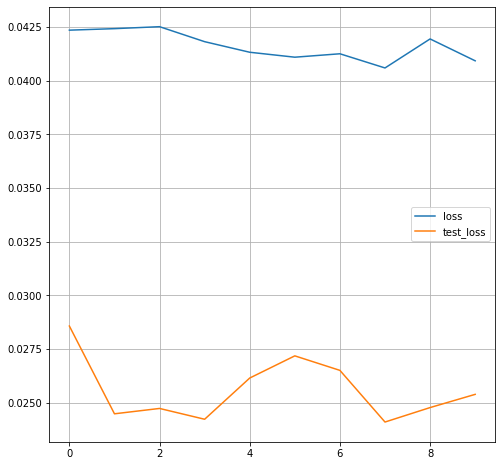

In [26]:
#10 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

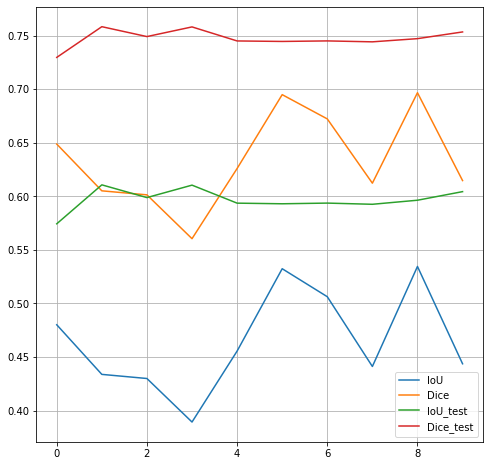

In [27]:
#10 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

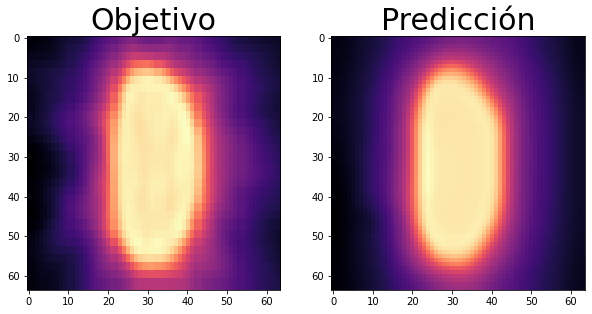

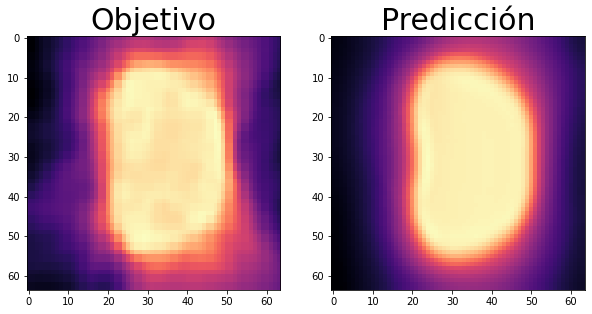

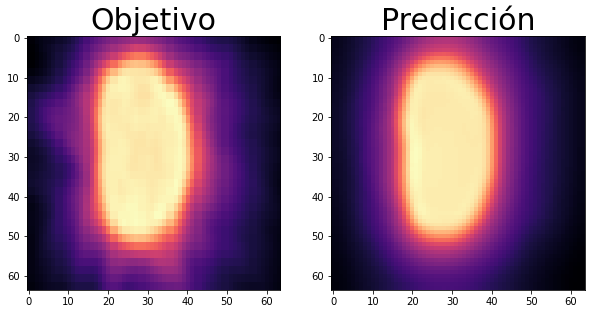

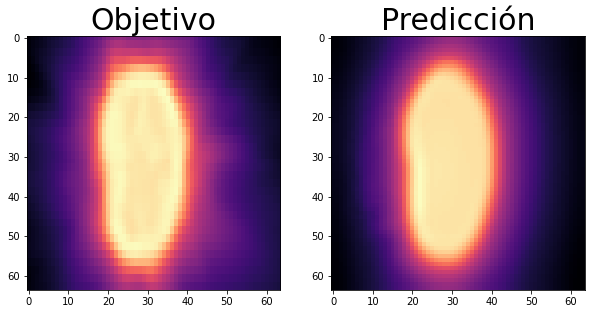

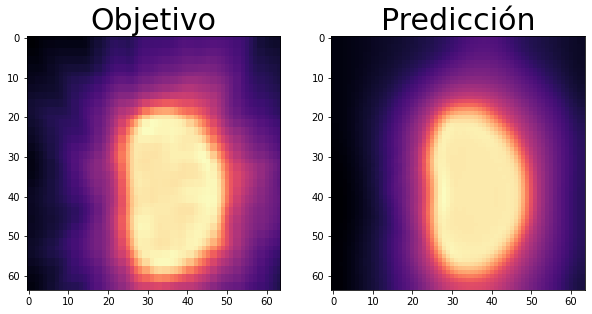

In [28]:
#10 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()

## * Entrenamiento de 100 épocas con torch.nn.L1Loss


In [19]:
hist, met = fit(epochs=100, loss_fn = torch.nn.L1Loss())


Epoch 1/100


test_loss 0.11066 iou 0.287 dice 0.446: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.38it/s]


Valid loss improved from inf to 0.1107. Saving checkpoint: file/checkpoint.pth

Epoch 2/100


test_loss 0.06991 iou 0.329 dice 0.495: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.40it/s]


Valid loss improved from 0.1107 to 0.0699. Saving checkpoint: file/checkpoint.pth

Epoch 3/100


test_loss 0.06498 iou 0.368 dice 0.537: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.12it/s]


Valid loss improved from 0.0699 to 0.0650. Saving checkpoint: file/checkpoint.pth

Epoch 4/100


test_loss 0.05010 iou 0.443 dice 0.614: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  8.14it/s]


Valid loss improved from 0.0650 to 0.0501. Saving checkpoint: file/checkpoint.pth

Epoch 5/100


test_loss 0.07532 iou 0.347 dice 0.515: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.35it/s]



Epoch 6/100


test_loss 0.05040 iou 0.396 dice 0.567: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]



Epoch 7/100


test_loss 0.06874 iou 0.349 dice 0.518: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.23it/s]



Epoch 8/100


test_loss 0.03843 iou 0.518 dice 0.682: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.11it/s]


Valid loss improved from 0.0501 to 0.0384. Saving checkpoint: file/checkpoint.pth

Epoch 9/100


test_loss 0.06247 iou 0.398 dice 0.569: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 10/100


test_loss 0.06599 iou 0.369 dice 0.539: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 11/100


test_loss 0.06595 iou 0.406 dice 0.578: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 12/100


test_loss 0.04844 iou 0.475 dice 0.644: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]



Epoch 13/100


test_loss 0.03732 iou 0.538 dice 0.700: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]


Valid loss improved from 0.0384 to 0.0373. Saving checkpoint: file/checkpoint.pth

Epoch 14/100


test_loss 0.03337 iou 0.532 dice 0.695: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.05it/s]


Valid loss improved from 0.0373 to 0.0334. Saving checkpoint: file/checkpoint.pth

Epoch 15/100


test_loss 0.03674 iou 0.527 dice 0.691: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.90it/s]



Epoch 16/100


test_loss 0.03384 iou 0.559 dice 0.717: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]



Epoch 17/100


test_loss 0.04619 iou 0.458 dice 0.628: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.99it/s]



Epoch 18/100


test_loss 0.03932 iou 0.482 dice 0.651: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 19/100


test_loss 0.03206 iou 0.553 dice 0.712: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.91it/s]


Valid loss improved from 0.0334 to 0.0321. Saving checkpoint: file/checkpoint.pth

Epoch 20/100


test_loss 0.04564 iou 0.459 dice 0.629: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 21/100


test_loss 0.03704 iou 0.486 dice 0.654: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.91it/s]



Epoch 22/100


test_loss 0.04398 iou 0.436 dice 0.607: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.99it/s]



Epoch 23/100


test_loss 0.04836 iou 0.447 dice 0.618: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.93it/s]



Epoch 24/100


test_loss 0.06438 iou 0.365 dice 0.535: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 25/100


test_loss 0.03790 iou 0.495 dice 0.662: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]



Epoch 26/100


test_loss 0.03873 iou 0.546 dice 0.707: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.11it/s]



Epoch 27/100


test_loss 0.03012 iou 0.580 dice 0.734: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.17it/s]


Valid loss improved from 0.0321 to 0.0301. Saving checkpoint: file/checkpoint.pth

Epoch 28/100


test_loss 0.03931 iou 0.508 dice 0.673: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.11it/s]



Epoch 29/100


test_loss 0.02841 iou 0.600 dice 0.750: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.15it/s]


Valid loss improved from 0.0301 to 0.0284. Saving checkpoint: file/checkpoint.pth

Epoch 30/100


test_loss 0.02855 iou 0.529 dice 0.692: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.15it/s]



Epoch 31/100


test_loss 0.03271 iou 0.568 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.21it/s]



Epoch 32/100


test_loss 0.03238 iou 0.516 dice 0.681: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.28it/s]



Epoch 33/100


test_loss 0.03396 iou 0.535 dice 0.697: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.21it/s]



Epoch 34/100


test_loss 0.02876 iou 0.564 dice 0.721: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.24it/s]



Epoch 35/100


test_loss 0.02917 iou 0.593 dice 0.744: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.24it/s]



Epoch 36/100


test_loss 0.03125 iou 0.514 dice 0.679: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.13it/s]



Epoch 37/100


test_loss 0.03166 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.07it/s]



Epoch 38/100


test_loss 0.02989 iou 0.579 dice 0.734: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.02it/s]



Epoch 39/100


test_loss 0.02867 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.10it/s]



Epoch 40/100


test_loss 0.03192 iou 0.530 dice 0.693: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 41/100


test_loss 0.02943 iou 0.562 dice 0.720: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 42/100


test_loss 0.02986 iou 0.583 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.93it/s]



Epoch 43/100


test_loss 0.03247 iou 0.568 dice 0.725: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.00it/s]



Epoch 44/100


test_loss 0.03076 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.91it/s]



Epoch 45/100


test_loss 0.03073 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.96it/s]



Epoch 46/100


test_loss 0.02552 iou 0.595 dice 0.746: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.88it/s]


Valid loss improved from 0.0284 to 0.0255. Saving checkpoint: file/checkpoint.pth

Epoch 47/100


test_loss 0.02570 iou 0.601 dice 0.751: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.03it/s]



Epoch 48/100


test_loss 0.03528 iou 0.549 dice 0.709: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 49/100


test_loss 0.02607 iou 0.595 dice 0.746: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.90it/s]



Epoch 50/100


test_loss 0.02769 iou 0.589 dice 0.742: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.98it/s]



Epoch 51/100


test_loss 0.02742 iou 0.573 dice 0.728: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.90it/s]



Epoch 52/100


test_loss 0.02892 iou 0.556 dice 0.715: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.01it/s]



Epoch 53/100


test_loss 0.02699 iou 0.583 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.91it/s]



Epoch 54/100


test_loss 0.02445 iou 0.609 dice 0.757: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.97it/s]


Valid loss improved from 0.0255 to 0.0244. Saving checkpoint: file/checkpoint.pth

Epoch 55/100


test_loss 0.03885 iou 0.499 dice 0.666: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  3.94it/s]



Epoch 56/100


test_loss 0.03233 iou 0.588 dice 0.741: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.43it/s]



Epoch 57/100


test_loss 0.03060 iou 0.561 dice 0.719: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.37it/s]



Epoch 58/100


test_loss 0.02805 iou 0.551 dice 0.710: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.04it/s]



Epoch 59/100


test_loss 0.02849 iou 0.581 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.20it/s]



Epoch 60/100


test_loss 0.03210 iou 0.558 dice 0.716: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]



Epoch 61/100


test_loss 0.02633 iou 0.605 dice 0.754: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]



Epoch 62/100


test_loss 0.02663 iou 0.581 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.42it/s]



Epoch 63/100


test_loss 0.02904 iou 0.528 dice 0.691: 100%|███████████████████████████████████████████| 30/30 [00:03<00:00,  7.50it/s]



Epoch 64/100


test_loss 0.02438 iou 0.600 dice 0.750: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.28it/s]


Valid loss improved from 0.0244 to 0.0244. Saving checkpoint: file/checkpoint.pth

Epoch 65/100


test_loss 0.02941 iou 0.548 dice 0.708: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.94it/s]



Epoch 66/100


test_loss 0.02676 iou 0.591 dice 0.743: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.95it/s]



Epoch 67/100


test_loss 0.02746 iou 0.578 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.32it/s]



Epoch 68/100


test_loss 0.02709 iou 0.582 dice 0.736: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.21it/s]



Epoch 69/100


test_loss 0.02343 iou 0.616 dice 0.763: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.29it/s]


Valid loss improved from 0.0244 to 0.0234. Saving checkpoint: file/checkpoint.pth

Epoch 70/100


test_loss 0.02552 iou 0.567 dice 0.724: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.24it/s]



Epoch 71/100


test_loss 0.02648 iou 0.579 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.46it/s]



Epoch 72/100


test_loss 0.02378 iou 0.597 dice 0.747: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.99it/s]



Epoch 73/100


test_loss 0.02563 iou 0.584 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  7.34it/s]



Epoch 74/100


test_loss 0.02535 iou 0.583 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.06it/s]



Epoch 75/100


test_loss 0.02741 iou 0.592 dice 0.744: 100%|███████████████████████████████████████████| 30/30 [00:09<00:00,  3.00it/s]



Epoch 76/100


test_loss 0.02530 iou 0.597 dice 0.747: 100%|███████████████████████████████████████████| 30/30 [00:08<00:00,  3.55it/s]



Epoch 77/100


test_loss 0.02528 iou 0.579 dice 0.733: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.06it/s]



Epoch 78/100


test_loss 0.02810 iou 0.580 dice 0.735: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.12it/s]



Epoch 79/100


test_loss 0.02345 iou 0.611 dice 0.758: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.09it/s]



Epoch 80/100


test_loss 0.02485 iou 0.614 dice 0.761: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.10it/s]



Epoch 81/100


test_loss 0.02401 iou 0.607 dice 0.755: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.22it/s]



Epoch 82/100


test_loss 0.02718 iou 0.592 dice 0.743: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.17it/s]



Epoch 83/100


test_loss 0.02936 iou 0.551 dice 0.711: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.15it/s]



Epoch 84/100


test_loss 0.02738 iou 0.587 dice 0.740: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.17it/s]



Epoch 85/100


test_loss 0.02342 iou 0.610 dice 0.758: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.21it/s]


Valid loss improved from 0.0234 to 0.0234. Saving checkpoint: file/checkpoint.pth

Epoch 86/100


test_loss 0.02665 iou 0.592 dice 0.744: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.09it/s]



Epoch 87/100


test_loss 0.03176 iou 0.517 dice 0.682: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.11it/s]



Epoch 88/100


test_loss 0.02826 iou 0.556 dice 0.714: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.18it/s]



Epoch 89/100


test_loss 0.02656 iou 0.584 dice 0.737: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.10it/s]



Epoch 90/100


test_loss 0.02353 iou 0.591 dice 0.743: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.07it/s]



Epoch 91/100


test_loss 0.02444 iou 0.590 dice 0.742: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.12it/s]



Epoch 92/100


test_loss 0.02416 iou 0.604 dice 0.753: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.15it/s]



Epoch 93/100


test_loss 0.02462 iou 0.593 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.14it/s]



Epoch 94/100


test_loss 0.02404 iou 0.600 dice 0.750: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.12it/s]



Epoch 95/100


test_loss 0.02348 iou 0.610 dice 0.757: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.15it/s]



Epoch 96/100


test_loss 0.02690 iou 0.577 dice 0.732: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.14it/s]



Epoch 97/100


test_loss 0.02493 iou 0.596 dice 0.747: 100%|███████████████████████████████████████████| 30/30 [00:06<00:00,  4.39it/s]



Epoch 98/100


test_loss 0.02557 iou 0.590 dice 0.742: 100%|███████████████████████████████████████████| 30/30 [00:07<00:00,  4.26it/s]



Epoch 99/100


test_loss 0.02478 iou 0.594 dice 0.745: 100%|███████████████████████████████████████████| 30/30 [00:05<00:00,  5.22it/s]



Epoch 100/100


test_loss 0.02391 iou 0.580 dice 0.734: 100%|███████████████████████████████████████████| 30/30 [00:04<00:00,  6.01it/s]


 Entrenamiento de 100 epocas finalizado en 97m 24s



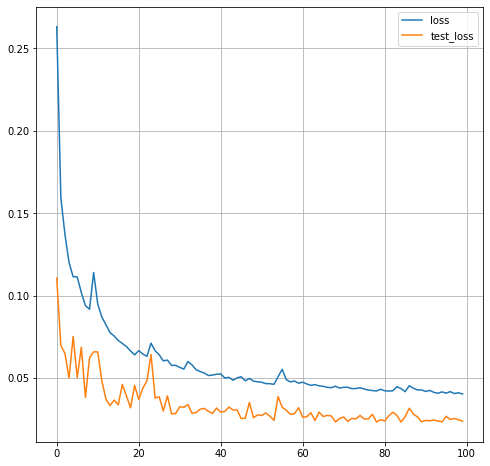

In [20]:
#100 epocas
df = pd.DataFrame(hist)
df.plot(grid=True, figsize=(8,8))
plt.show()

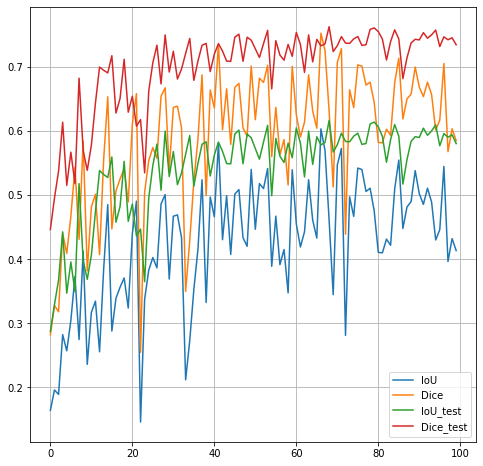

In [21]:
#100 epocas
df = pd.DataFrame(met)
df.plot(grid=True, figsize=(8,8))
plt.show()

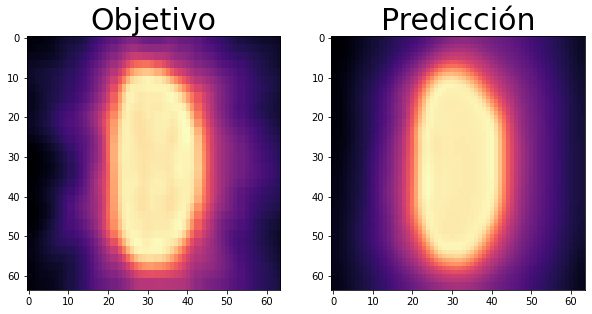

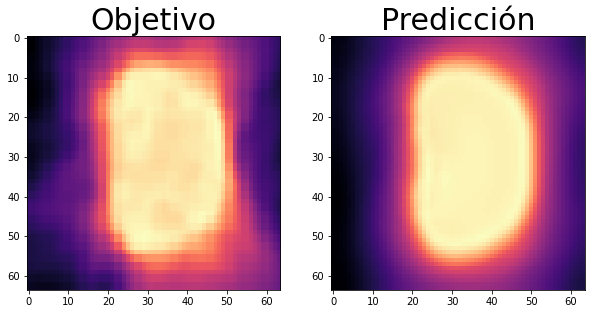

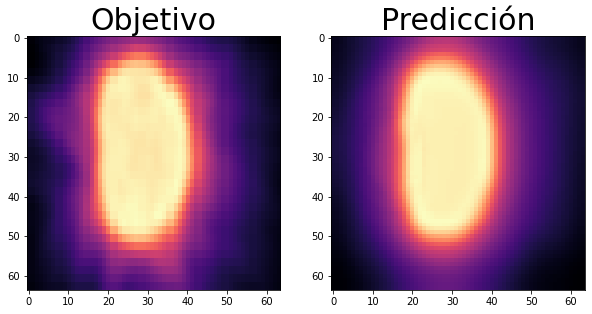

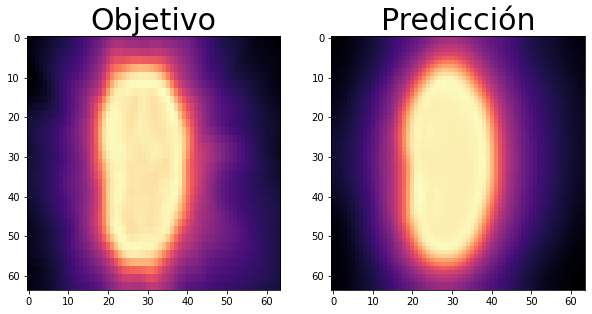

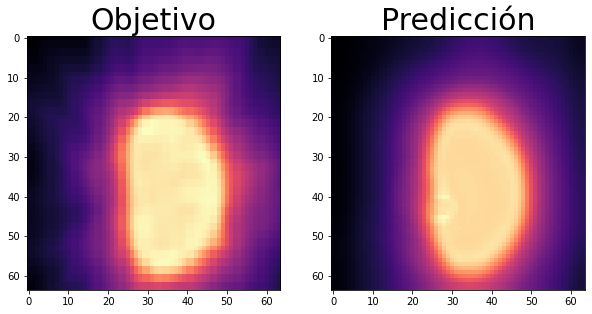

In [22]:
#100 epocas
model.eval()
for i in range(5):
    with torch.no_grad():
        ix = random.randint(0, len(dataset['test'])-1)
        img, mask = dataset['test'][ix]
        output = model(img.unsqueeze(0).to(device, dtype=torch.float))[0]
        pred_mask = output
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
    ax1.set_title('Objetivo', fontsize=30)
    ax1.imshow(mask[:,:,:,29].permute(1,2,0),cmap="magma")
    ax2.set_title('Predicción', fontsize=30)
    ax2.imshow(pred_mask.squeeze().cpu().numpy()[:,:,29],cmap="magma")
    plt.show()